In [1]:
#!/usr/bin/env python 

'''
-Initially make z_to_x and x_to_z fairly shallow networks.  Inject noise?  

-Use the fflayer class?  

'''
import sys

sys.path.append("/u/lambalex/DeepLearning/undirected_matching")
sys.path.append("/u/lambalex/DeepLearning/undirected_matching/lib")

import theano
import theano.tensor as T
from nn_layers import fflayer, param_init_fflayer, param_init_convlayer, convlayer
from utils import init_tparams, join2, srng, dropout, inverse_sigmoid, join3, merge_images
from loss import accuracy, crossent, lsgan_loss, wgan_loss, improvement_loss
import lasagne
import numpy as np
import numpy.random as rng
import gzip
import cPickle as pickle
import random
from viz import plot_images
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import os
slurm_name = os.environ["SLURM_JOB_ID"]

Using cuDNN version 5105 on context None
Mapped name None to device cuda0: Quadro K6000 (0000:03:00.0)
/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class ConsiderConstant(theano.compile.ViewOp):
    def grad(self, args, g_outs):
        return [T.zeros_like(g_out) for g_out in g_outs]

consider_constant = ConsiderConstant()

#dataset = "mnist"
#dataset = "anime"
dataset = "svhn"

if dataset == "mnist":
    mn = gzip.open("/u/lambalex/data/mnist/mnist.pkl.gz")

    train, valid, test = pickle.load(mn)

    trainx,trainy = train
    
    
    #newtx = trainx[(trainy<2) | (trainy>8)]
    #newty = trainy[(trainy<2) | (trainy>8)]
    #trainx = newtx
    #trainy = newty
    
    validx,validy = valid
    testx, testy = test

    num_examples = trainx.shape[0]

    m = 784
elif dataset == "anime":
    from load_file import FileData, normalize, denormalize

    loc = "/u/lambalex/DeepLearning/animefaces/datafaces/danbooru-faces/"

    animeData = FileData(loc, 32, 64)

    m = 32*32*3

elif dataset == "svhn":

    from load_svhn import SvhnData
    from load_file import normalize, denormalize

    svhnData = SvhnData(mb_size=64,segment="train")

    num_examples = 50000

nl = 128
print "num latent", nl
#128 works for nl
nfg = 512
nfd = 512

print "dataset", dataset

#3
num_steps = 1
print "num steps", num_steps

train_classifier_separate = True
print "train classifier separate", train_classifier_separate

#skip_conn = True
#print "skip conn", skip_conn

latent_sparse = False
print "latent sparse", latent_sparse

persist_p_chain = False
print "persistent p chain", persist_p_chain

blending_rate = 0.5
print 'blending rate (odds of keeping old z in P chain)', blending_rate

improvement_loss_weight = 0.0
print "improvement loss weight", improvement_loss_weight

shape (574168, 3, 32, 32)
svhn shape (574168, 3, 32, 32)
0 255
num latent 128
dataset svhn
num steps 1
train classifier separate True
latent sparse False
persistent p chain False
blending rate (odds of keeping old z in P chain) 0.5
improvement loss weight 0.0


In [3]:
def init_gparams(p):

    p = param_init_fflayer(options={},params=p,prefix='z_x_1',nin=nl*2,nout=512*4*4,ortho=False,batch_norm=True)

    p = param_init_convlayer(options={},params=p,prefix='z_x_2',nin=512,nout=256,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='z_x_3',nin=256*1,nout=128,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='z_x_4',nin=128*1,nout=3,kernel_len=5,batch_norm=False)

    p = param_init_convlayer(options={},params=p,prefix='x_z_1',nin=3,nout=128,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='x_z_2',nin=128,nout=256,kernel_len=5,batch_norm=True)
    p = param_init_convlayer(options={},params=p,prefix='x_z_3',nin=256,nout=512,kernel_len=5,batch_norm=True)

    p = param_init_fflayer(options={},params=p,prefix='x_z_mu',nin=512*4*4,nout=nl,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='x_z_sigma',nin=512*4*4,nout=nl,ortho=False,batch_norm=False)

    return init_tparams(p)

def init_dparams(p):

    p = param_init_convlayer(options={},params=p,prefix='DC_1',nin=3,nout=128,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='DC_2',nin=128,nout=256,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='DC_3',nin=256,nout=512,kernel_len=5,batch_norm=False)

    p = param_init_fflayer(options={},params=p,prefix='D_1',nin=nl+512*4*4,nout=nfd,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='D_2',nin=nfd,nout=nfd,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='D_3',nin=nfd,nout=nfd,ortho=False,batch_norm=False)

    p = param_init_fflayer(options={},params=p,prefix='D_o_1',nin=nfd,nout=1,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='D_o_2',nin=nfd,nout=1,ortho=False,batch_norm=False)
    p = param_init_fflayer(options={},params=p,prefix='D_o_3',nin=nfd,nout=1,ortho=False,batch_norm=False)

    p = param_init_convlayer(options={},params=p,prefix='D_o_4',nin=128,nout=1,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='D_o_5',nin=256,nout=1,kernel_len=5,batch_norm=False)
    p = param_init_convlayer(options={},params=p,prefix='D_o_6',nin=512,nout=1,kernel_len=5,batch_norm=False)

    return init_tparams(p)


def z_to_x(p,z):

    print "extra noise input"
    z_inp = join2(z, 1.0*srng.normal(size=z.shape))

    d0 = fflayer(tparams=p,state_below=z_inp,options={},prefix='z_x_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)')

    d0 = d0.reshape((64,512,4,4))

    d1 = convlayer(tparams=p,state_below=d0,options={},prefix='z_x_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=-2)

    d2 = convlayer(tparams=p,state_below=d1,options={},prefix='z_x_3',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=-2)

    d3 = convlayer(tparams=p,state_below=d2,options={},prefix='z_x_4',activ='lambda x: x',stride=-2)

    x_new = d3.flatten(2)

    return x_new

def x_to_z(p,x):

    e1 = convlayer(tparams=p,state_below=x.reshape((64,3,32,32)),options={},prefix='x_z_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    e2 = convlayer(tparams=p,state_below=e1,options={},prefix='x_z_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    e3 = convlayer(tparams=p,state_below=e2,options={},prefix='x_z_3',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    eo = e3
    eo = eo.flatten(2)

    sigma = fflayer(tparams=p,state_below=eo,options={},prefix='x_z_mu',activ='lambda x: x')
    mu = fflayer(tparams=p,state_below=eo,options={},prefix='x_z_sigma',activ='lambda x: x')

    eps = srng.normal(size=sigma.shape)

    z_new = eps*T.nnet.sigmoid(sigma) + mu
    print "turned on injected noise in x->z connection"

    z_new = (z_new - T.mean(z_new, axis=0, keepdims=True)) / (0.001 + T.std(z_new, axis=0, keepdims=True))

    return z_new


def discriminator(p,x,z):

    dc_1 = convlayer(tparams=p,state_below=x.reshape((64,3,32,32)),options={},prefix='DC_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    dc_2 = convlayer(tparams=p,state_below=dc_1,options={},prefix='DC_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    dc_3 = convlayer(tparams=p,state_below=dc_2,options={},prefix='DC_3',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',stride=2)

    inp = join2(z,dc_3.flatten(2))

    h1 = fflayer(tparams=p,state_below=inp,options={},prefix='D_1',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)',mean_ln=False)

    h2 = fflayer(tparams=p,state_below=h1,options={},prefix='D_2',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)', mean_ln=False)

    h3 = fflayer(tparams=p,state_below=h2,options={},prefix='D_3',activ='lambda x: tensor.nnet.relu(x,alpha=0.02)', mean_ln=False)

    D1 = fflayer(tparams=p,state_below=h1,options={},prefix='D_o_1',activ='lambda x: x')
    D2 = fflayer(tparams=p,state_below=h2,options={},prefix='D_o_2',activ='lambda x: x')
    D3 = fflayer(tparams=p,state_below=h3,options={},prefix='D_o_3',activ='lambda x: x')

    D4 = convlayer(tparams=p,state_below=dc_1,options={},prefix='D_o_4',activ='lambda x: x',stride=2)
    D5 = convlayer(tparams=p,state_below=dc_2,options={},prefix='D_o_5',activ='lambda x: x',stride=2)
    D6 = convlayer(tparams=p,state_below=dc_3,options={},prefix='D_o_6',activ='lambda x: x',stride=2)

    print "special thing in D"
    return [D1,D2,D3,D4,D5,D6], h3

def p_chain(p, z, num_iterations):
    zlst = [z]
    xlst = []

    if num_iterations == 1:
        
        new_x = z_to_x(p, zlst[-1])
        xlst.append(new_x)
        #new_z = x_to_z(p, xlst[-1])
        #zlst.append(new_z)

    elif num_iterations == 3:  

        new_x = z_to_x(p, zlst[-1])
        xlst.append(new_x)
        new_z = x_to_z(p, consider_constant(xlst[-1]))
        zlst.append(new_z)

        new_x = z_to_x(p, zlst[-1])
        xlst.append(new_x)
        new_z = x_to_z(p, consider_constant(xlst[-1]))
        zlst.append(new_z)

        new_x = z_to_x(p, zlst[-1])
        xlst.append(new_x)

    else:

        for inds in range(0,num_iterations):
            new_x = z_to_x(p, zlst[-1])
            xlst.append(new_x)
            new_z = x_to_z(p, xlst[-1])
            zlst.append(new_z)


    for j in range(len(xlst)):
        xlst[j] = T.nnet.sigmoid(xlst[j])

    return xlst, zlst

def onestep_z_to_x(p,z):
    x = T.nnet.sigmoid(z_to_x(p, z))
    return x

def onestep_x_to_z(p,x):
    new_z = x_to_z(p, inverse_sigmoid(x))
    return new_z

def q_chain(p,x,num_iterations):

    xlst = [x]
    zlst = []
    new_z = x_to_z(p, inverse_sigmoid(xlst[-1]))
    zlst.append(new_z)

    return xlst, zlst

In [4]:
gparams = init_gparams({})
dparams = init_dparams({})

z_in = T.matrix('z_in')
x_in = T.matrix()

p_lst_x,p_lst_z = p_chain(gparams, z_in, num_steps)

q_lst_x,q_lst_z = q_chain(gparams, x_in, num_steps)

p_lst_x_long,p_lst_z_long = p_chain(gparams, z_in, 19)

z_inf = q_lst_z[-1]

print p_lst_x
print p_lst_z
print q_lst_x
print q_lst_z

#D_p_lst_3,_ = discriminator(dparams, p_lst_x[2], p_lst_z[2])

#D_p_lst_2,_ = discriminator(dparams, p_lst_x[1], p_lst_z[1])

D_p_lst_1,_ = discriminator(dparams, p_lst_x[0], p_lst_z[0])

D_q_lst,D_feat_q = discriminator(dparams, q_lst_x[-1], q_lst_z[-1])

dloss, gloss = lsgan_loss(D_q_lst, D_p_lst_1)

print "single disc"
print "not using improvement objective"
#improvement_objective = improvement_loss_weight * improvement_loss(D_p_lst_1, D_p_lst_2)
#gloss += improvement_objective

lr = theano.shared(np.array(0.0001, dtype=theano.config.floatX))

dupdates = lasagne.updates.rmsprop(dloss, dparams.values(),lr)
gloss_grads = T.grad(gloss, gparams.values(), disconnected_inputs='ignore')
gupdates = lasagne.updates.rmsprop(gloss_grads, gparams.values(),lr)

gcupdates = lasagne.updates.rmsprop(gloss, gparams.values(),lr)

dgupdates = dupdates.copy()
dgupdates.update(gupdates)

dgcupdates = dupdates.copy()
dgcupdates.update(gcupdates)

train_disc_gen_classifier = theano.function(inputs = [x_in, z_in], outputs=[dloss,p_lst_x[-1],p_lst_z[-1]], updates=dgcupdates,on_unused_input='ignore')

get_zinf = theano.function([x_in], outputs=z_inf)
#get_dfeat = theano.function([x_in], outputs=D_feat_q)

#get_pchain = theano.function([z_in], outputs = p_lst_x_long)

x_in = T.matrix()

func_z_to_x = theano.function([z_in], outputs = onestep_z_to_x(gparams, z_in))
func_x_to_z = theano.function([x_in], outputs = onestep_x_to_z(gparams, x_in))



extra noise input


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Quadro K6000 (CNMeM is disabled, cuDNN 5105)


turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned on injected noise in x->z connection
extra noise input
turned o

In [5]:
print "a"

a


In [6]:
lr.set_value(0.0001)

In [ ]:
z_out_p = rng.normal(size=(64,nl)).astype('float32')

for iteration in range(0,500000):

    if persist_p_chain:
        z_in_new = rng.normal(size=(64,nl)).astype('float32')
        blending = rng.uniform(0.0,1.0,size=(64,))
        z_in_new[blending>=blending_rate] = z_out_p[blending>=blending_rate]
        z_in = z_in_new
    else:
        z_in = rng.normal(size=(64,nl)).astype('float32')

    if latent_sparse:
        z_in[:,128:] *= 0.0

    r = random.randint(0,num_examples-64)

    if dataset == "mnist":
        x_in = trainx[r:r+64]
        y_in = trainy[r:r+64]

        x_in = x_in.reshape((64,1,28,28))

        x_in = np.repeat(x_in,3,axis=(1))
        x_in = np.lib.pad(x_in,((0,0),(0,0),(2,2),(2,2)),'constant',constant_values=(0))

        x_in = x_in.reshape((64,32*32*3))
    elif dataset == "anime":
        x_in = normalize(animeData.getBatch()).reshape((64,32*32*3))

    elif dataset == "svhn":
        x_in = normalize(svhnData.getBatch()['x']).reshape((64,32*32*3))

    dloss,gen_x,z_out_p = train_disc_gen_classifier(x_in,z_in)


    print "iteration", iteration, "dloss", dloss, "gen_x mean", gen_x.mean()

    if iteration+1 % 1000 == 0:
        print "dloss", dloss
        plot_images(gen_x, "plots/" + slurm_name + "_gen.png")
        #plot_images(reconstruct(x_in).reshape((64,1,28,28)), "plots/" + slurm_name + "_rec.png")

        #NOT CORRECT INITIALLY
        #rec_loop = [x_in]
        #for b in range(0,9):
        #    rec_loop.append(reconstruct(rec_loop[-1]))
        #    rec_loop[-1][:,0:392] = x_in[:,0:392]
        #    plot_images(rec_loop[-1].reshape((64,1,28,28)), "plots/" + slurm_name + "_rec_" + str(b) +".png")

        plot_images(x_in, "plots/" + slurm_name + "_original.png")

        #p_chain = get_pchain(z_in)
        new_z = rng.normal(size=(64,nl)).astype('float32')
        for j in range(0,20):
            new_x = func_z_to_x(new_z)
            new_z = func_x_to_z(new_x)
            print "printing element of p_chain", j
            plot_images(new_x, "plots/" + slurm_name + "_pchain_" + str(j) + ".png")

        new_z = rng.normal(size=(64,nl)).astype('float32')
        for j in range(0,20):
            new_x = func_z_to_x(new_z)
            new_x = merge_images(new_x, x_in)
            new_z = func_x_to_z(new_x)
            plot_images(new_x, "plots/" + slurm_name + "_inpainting_" + str(j) + ".png")



iteration 0 dloss 0.712442874908 gen_x mean 0.666354
iteration 1 dloss 0.734126985073 gen_x mean 0.672445
iteration 2 dloss 0.726332366467 gen_x mean 0.678566
iteration 3 dloss 0.729262530804 gen_x mean 0.684103
iteration 4 dloss 0.718593597412 gen_x mean 0.689643
iteration 5 dloss 0.738784193993 gen_x mean 0.694876
iteration 6 dloss 0.716775417328 gen_x mean 0.699961
iteration 7 dloss 0.715963125229 gen_x mean 0.704716
iteration 8 dloss 0.709205389023 gen_x mean 0.709485
iteration 9 dloss 0.729478061199 gen_x mean 0.713917
iteration 10 dloss 0.697027087212 gen_x mean 0.71828
iteration 11 dloss 0.70736593008 gen_x mean 0.722312
iteration 12 dloss 0.714556932449 gen_x mean 0.726168
iteration 13 dloss 0.715145111084 gen_x mean 0.730065
iteration 14 dloss 0.693262994289 gen_x mean 0.733834
iteration 15 dloss 0.714337050915 gen_x mean 0.737288
iteration 16 dloss 0.71940946579 gen_x mean 0.740675
iteration 17 dloss 0.688550651073 gen_x mean 0.743654
iteration 18 dloss 0.707033336163 gen_x m

In [31]:
svhnData.getBatch()['x'].shape

(64, 3, 32, 32)

In [13]:
svhnData.train_X.shape

(574168, 3, 32, 32)

In [ ]:
soa_trainx = svhnData.train_X[:1000]
soa_trainy = svhnData.train_Y[:1000]

In [35]:
soa_trainx.shape

(1000, 3, 32, 32)

In [36]:
soa_trainy.shape

(1000, 1)

In [37]:

x_under_test = normalize(soa_trainx[:64]).reshape((64,32*32*3))

z_under_test = func_x_to_z(x_in_test)

In [38]:
x_under_test.shape

(64, 3072)

In [39]:
z_under_test.shape

(64, 128)

In [43]:
%matplotlib inline

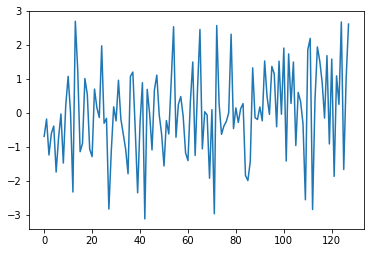

In [44]:
plt.plot(z_under_test[1])